In [1]:
from dask import delayed
import numpy as np
import random
import dask
import dask.array as da
import os
import matplotlib.pyplot as plt
import zarr
import bcolz
import cupy as cp
from cucim import CuImage
from dask.distributed import as_completed
from dask.distributed import Client, LocalCluster

In [2]:
# Setup a local cluster.
cluster = LocalCluster(dashboard_address= 8789, processes=True)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34707 Dashboard: http://127.0.0.1:8789/status,Cluster Workers: 8 Cores: 64 Memory: 201.36 GB


82944 126976


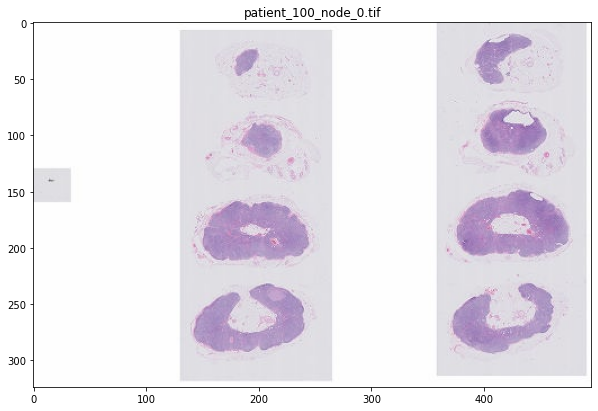

In [4]:
input_file = "patient_100_node_0.tif"
wsi = CuImage(input_file)

sizes=wsi.metadata["cucim"]["resolutions"]
levels = sizes["level_count"]
w = sizes["level_dimensions"][0][0]
h = sizes["level_dimensions"][0][1]

wt = sizes["level_dimensions"][levels-1][0]
ht = sizes["level_dimensions"][levels-1][1]

wsi_thumb = wsi.read_region(location=(0,0), size=(wt,ht), level=levels-1)

plt.figure(figsize=(10,10))
plt.imshow(wsi_thumb)
plt.title('patient_100_node_0.tif')
print(h,w)
plt.show()

In [6]:
# evaluates whether the block contains tissue to analyse
def threshold(arr,x,y):
    
    if arr.flatten().var() > 100:
        return (x,y)
    else:
        return None

# iterate over a set of regions from which to threshold
def process_chunk(params):
    start_loc_list = params[0]
    inp_file = params[1]
    patch_size = params[2]
    slide = CuImage(inp_file)
    res = []
    for start_loc in start_loc_list:
        region = np.array(slide.read_region(start_loc, [patch_size, patch_size], 0))
        if threshold(region, start_loc[0], start_loc[1]):
            res.append((start_loc[0], start_loc[1]))
            assert region.shape==(patch_size,patch_size,3)
        
    return res

# iterate over a set of regions from which to threshold
def process_chunk_cache_tile(params):
    start_loc_list = params[0]
    inp_file = params[1]
    patch_size = params[2]
    slide = CuImage(inp_file)
    res = []
    for start_loc in start_loc_list:
        region = np.array(slide.read_region(start_loc, [patch_size, patch_size], 0))
        if threshold(region, start_loc[0], start_loc[1]):
            res.append((start_loc[0], start_loc[1],region))
        
    return res

# As the results are processed, put them into a list
def compile_results(futures):
    patches = []

    for future in as_completed(futures):
        res1 = future.result()
        if res1:
            for patch in res1:
                patches.append(patch)
                
    return patches

In [7]:
%%time

patch_size = 256
tile_size = 64

num_processes = os.cpu_count()

start_loc_data = [(sx, sy)
                  for sy in range(0, h, patch_size)
                      for sx in range(0, w, patch_size)]

chunk_size = len(start_loc_data) // num_processes

start_loc_list_iter = [(start_loc_data[i:i+chunk_size],input_file,patch_size)  for i in range(0, len(start_loc_data), chunk_size)]
future_result1 = list(client.map(process_chunk, start_loc_list_iter))
patches = compile_results(future_result1)
                 
#now map each patch to a process
chunk_size = len(patches) // num_processes   

start_loc_data = [(sx+res[0], sy+res[1])
                  for res in patches
                      for sy in range(0, patch_size, tile_size)
                          for sx in range(0, patch_size, tile_size)]

start_loc_list_iter2 = [(start_loc_data[i:i+chunk_size],input_file,tile_size)  for i in range(0, len(start_loc_data), chunk_size)]
future_result2 = list(client.map(process_chunk_cache_tile, start_loc_list_iter2))
tiles = compile_results(future_result2)

print(len(tiles))

389061
CPU times: user 24.9 s, sys: 10.1 s, total: 35 s
Wall time: 1min


In [10]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)
    
class VAE2(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        #print(z.shape)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
    
model2 = VAE2(image_channels=3)
model2 = torch.nn.DataParallel(model2, device_ids=[0,1])
model2.cuda()

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False
def loss_function2(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # https://arxiv.org/abs/1312.6114 (Appendix B)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    KLD /= 1600 * 32 * 32
    return BCE + KLD

optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)

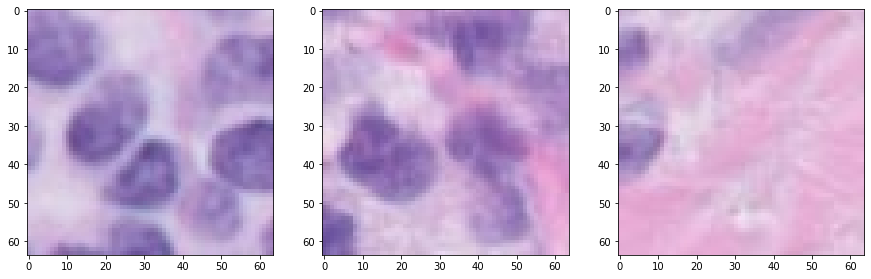

In [8]:
fig, ax = plt.subplots(1,3,figsize = (15,15))
i = random.randint(0,len(tiles)-1)
ax[0].imshow(tiles[i][2])
i = random.randint(0,len(tiles)-1)
ax[1].imshow(tiles[i][2])
i = random.randint(0,len(tiles)-1)
ax[2].imshow(tiles[i][2])


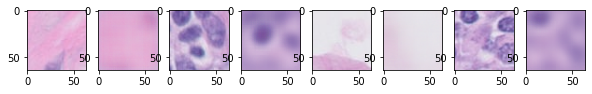

In [11]:
model2 = VAE2(image_channels=3)
model2 = torch.nn.DataParallel(model2, device_ids=[0,1])
dct = torch.load('M2_WEIGHTS.PT')
model2.load_state_dict(dct['state_dict'])
model2.cuda()

model2.eval()

bs = len(tiles) // 128

batch_list = [i for i in range(len(tiles))]
random.shuffle(batch_list)
batch=np.zeros((512,3,tile_size,tile_size),np.uint8)

if len(batch_list)>=512:

    for p in range(512):
        j = batch_list.pop()
        tile = np.moveaxis(tiles[j][2],2,0)
        batch[p]=tile
        

    tiles_cuda=torch.FloatTensor(batch).cuda()
    tiles_cuda=tiles_cuda/255

    recon_batch, _, _ = model2(tiles_cuda)

    tensor1 = recon_batch.cpu().detach().numpy() * 255
    tensor1 = tensor1.astype(np.uint8)
    tensor2 = tiles_cuda.cpu().numpy() * 255
    tensor2 = tensor2.astype(np.uint8)
    fig, ax = plt.subplots(1,8,figsize = (10,10))
    ax[0].imshow(np.moveaxis(tensor2[20,:,:,:],0,2))
    ax[1].imshow(np.moveaxis(tensor1[20,:,:,:],0,2))
    ax[2].imshow(np.moveaxis(tensor2[25,:,:,:],0,2))
    ax[3].imshow(np.moveaxis(tensor1[25,:,:,:],0,2))
    ax[4].imshow(np.moveaxis(tensor2[120,:,:,:],0,2))
    ax[5].imshow(np.moveaxis(tensor1[120,:,:,:],0,2))
    ax[6].imshow(np.moveaxis(tensor2[127,:,:,:],0,2))
    ax[7].imshow(np.moveaxis(tensor1[127,:,:,:],0,2))
    plt.show()


